<a href="https://www.javeriana.edu.co/inicio"><img src = "https://www.javeriana.edu.co/construye-futuro/wp-content/uploads/2021/02/javeriana-web-logo-edu.png" width = 600, align = "center"></a>


<h1><center>Machine Learning Method</center></h1>


<h4>About this Notebook</h4>
In this notebook, we learn how to use scikit-learn to implement simple linear regression. We download a dataset that is related to fuel consumption and Carbon dioxide emission of cars. Then, we split our data into training and test sets, create a model using training set, evaluate your model using test set, and finally use model to predict unknown value.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#understanding_data">Understanding the Data</a></li>
        <li><a href="#reading_data">Reading the data in</a></li>
        <li><a href="#data_exploration">Data Exploration</a></li>
        <li><a href="#simple_regression">Simple Regression Model</a></li>
    </ol>
</div>
<br>
<hr>

## Importing Needed packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error as mse

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
import multiprocessing

## Downloading Data
To download the data, we will use !wget to download it from IBM Object Storage.

In [3]:
#!wget -O MY2022_Fuel_Consumption_Ratings.csv https://www.nrcan.gc.ca/sites/nrcan/files/oee/files/csv/MY2022%20Fuel%20Consumption%20Ratings.csv


<h2 id="understanding_data">Understanding the Data</h2>

### `MY2022_Fuel_Consumption_Ratings.csv`:
We have downloaded a fuel consumption dataset, **`MY2022 Fuel Consumption Ratings.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)

- **MODELYEAR** e.g. 2022
- **MAKE** e.g. Acura
- **MODEL** e.g. ILX
- **VEHICLE CLASS** e.g. Compact
- **ENGINE SIZE** e.g. 2.4
- **CYLINDERS** e.g 4
- **TRANSMISSION** e.g. AM8
- **FUEL** e.g. Z

- **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
- **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 7
- **FUEL CONSUMPTION COMB (L/100 km)** e.g. 8.6
- **CO2 EMISSIONS (g/km)** e.g. 200   --> 6
- **SMOG** e.g. 3


<h2 id="reading_data">Reading the data in</h2>

In [4]:
emissions_df = pd.read_csv("Fuel_Consumption_Ratings.csv", encoding='cp1252',
                 nrows=882, usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14], index_col=False)

# take a look at the dataset
emissions_df.tail(3)

,Make,Model,Vehicle Class,Engine_Size,Cylinders,Transmission,Fuel,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb_mpg,CO2_Emissions,CO2_Rating,Smog_Rating
879,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232,5,7
880,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236,5,5
881,Volvo,XC90 T6 AWD,SUV: Standard,2.0,4,AS8,Z,12.4,8.9,10.8,26,252,5,7


<h2 id="data_exploration">Data Exploration</h2>
Lets first have a descriptive exploration on our data.

In [5]:
# summarize the data
emissions_df.describe()

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,Fuel_Consumption_Comb_mpg,CO2_Emissions,CO2_Rating,Smog_Rating
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,3.117234,5.600907,12.392404,9.320295,11.009751,27.486395,257.041950,4.595238,5.004535
std,1.317316,1.941692,3.471466,2.306278,2.899504,7.802495,64.782264,1.479523,1.630436
min,1.200000,3.000000,4.000000,3.900000,4.000000,11.000000,94.000000,1.000000,1.000000
25%,2.000000,4.000000,10.100000,7.600000,9.000000,22.000000,211.000000,4.000000,3.000000
50%,3.000000,6.000000,12.100000,9.100000,10.700000,26.000000,254.000000,5.000000,5.000000
75%,3.600000,6.000000,14.500000,10.600000,12.700000,31.000000,298.000000,5.000000,6.000000
max,8.000000,16.000000,30.300000,20.900000,26.100000,71.000000,608.000000,10.000000,7.000000


Lets select some features to explore more.

In [6]:
emissions_df = emissions_df[['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy','Fuel_Consumption_Comb','CO2_Emissions','CO2_Rating','Smog_Rating']]
emissions_df.sample(4)

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,Fuel_Consumption_Comb,CO2_Emissions,CO2_Rating,Smog_Rating
199,5.3,8,15.1,11.3,13.4,314,3,6
879,2.0,4,11.0,8.7,9.9,232,5,7
844,2.5,4,6.6,6.5,6.6,154,7,7
90,3.0,6,14.5,10.2,12.6,292,4,5


we can plot each of these features:

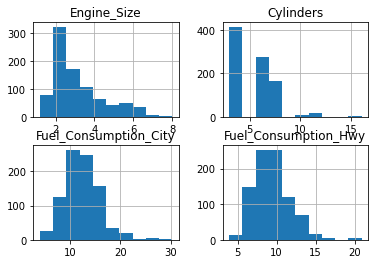

In [7]:
viz = emissions_df[['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy']]
viz.hist()
plt.show()

Now, lets plot each of these features vs the Emission, to see how linear is their relation:

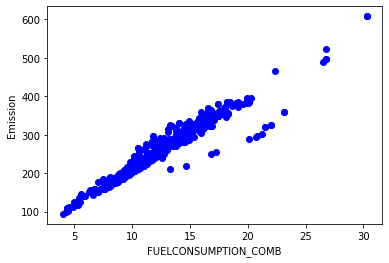

In [8]:
plt.scatter(emissions_df['Fuel_Consumption_City'], emissions_df['CO2_Emissions'],  color='blue')
plt.xlabel("FUELCONSUMPTION_COMB")
plt.ylabel("Emission")
plt.show()

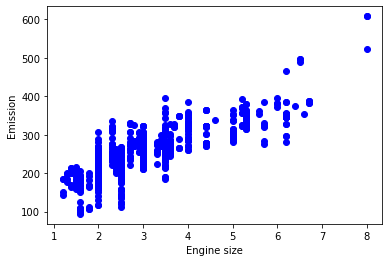

In [9]:
plt.scatter(emissions_df['Engine_Size'], emissions_df['CO2_Emissions'],  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

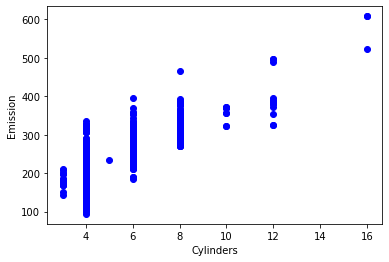

In [10]:
plt.scatter(emissions_df['Cylinders'], emissions_df['CO2_Emissions'], color='blue')
plt.xlabel('Cylinders')
plt.ylabel('Emission')
plt.show()

<AxesSubplot:>

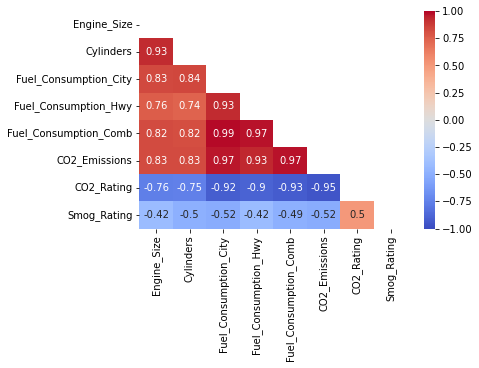

In [11]:
upp_mat = np.triu(emissions_df.corr())
sns.heatmap(emissions_df.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

## Separate features and target in different datasets

In [12]:
X =  emissions_df[['Engine_Size','Cylinders','Fuel_Consumption_City','Fuel_Consumption_Hwy']]
y =  emissions_df['CO2_Emissions']

### Apply Principal Component Analysis

In [13]:
# n_components = min(n_muestras, n_feactures)
pca = PCA(n_components=3)
pca.fit(X)

PCA(n_components=3)

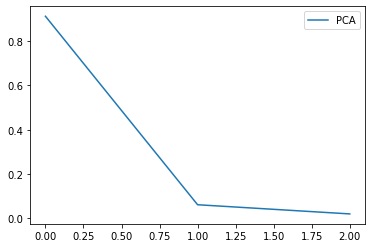

In [14]:
plt.plot(range(len(pca.explained_variance_)), pca.explained_variance_ratio_)
plt.legend(['PCA'])
plt.show()

### Normalize

In [15]:
#X = StandardScaler().fit_transform(X)

## The dataset is separated into a training set and a test set

### Creating train and test dataset
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.

This means that we know the outcome of each data point in this dataset, making it great to test with! And since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Lets split our dataset into train and test sets, 70% of the entire data for training, and the 30% for testing. 

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h2 id="simple_regression">Simple Regression Model</h2>
Linear Regression fits a linear model with coefficients $\theta = (\theta_1, ..., \theta_n)$ to minimize the 'residual sum of squares' between the independent x in the dataset, and the dependent y by the linear approximation. 

## Model

In [17]:
stimators = {'Linear':LinearRegression(),
            'Lasso': Lasso(alpha=0.02),
            'Ridge': Ridge(alpha=1)}

****************************************************************
Linear
MSE: 7.5023996350735525
R2-score: 0.95
intecep: 21.737655663753117  Coeficient: [ 0.39502355  3.0100433  11.2690848   8.33262087]


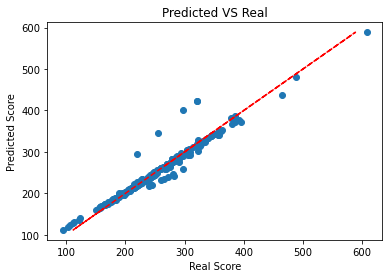

****************************************************************
Lasso
MSE: 7.504974519857291
R2-score: 0.95
intecep: 21.761803185442886  Coeficient: [ 0.37204819  3.00668214 11.28683681  8.31615104]


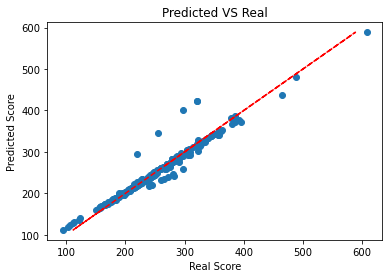

****************************************************************
Ridge
MSE: 7.506425617426513
R2-score: 0.95
intecep: 21.773595935396145  Coeficient: [ 0.40899692  3.00574934 11.26711093  8.32930888]


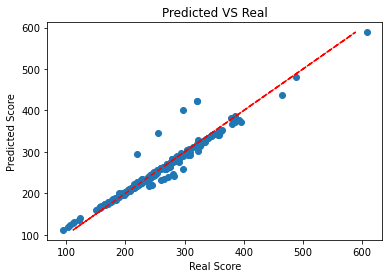

In [18]:
for name, stimator in stimators.items():
    stimator.fit(X_train,y_train)
    predictions = stimator.predict(X_test)
    print('*'*64)
    print(name)
    print('MSE:', mean_absolute_error(y_test, predictions))
    print("R2-score: %.2f" % r2_score(y_test, predictions))
    print('intecep:',stimator.intercept_,' Coeficient:',stimator.coef_)

    plt.ylabel('Predicted Score')
    plt.xlabel('Real Score')
    plt.title('Predicted VS Real')
    plt.scatter(y_test, predictions)
    plt.plot(predictions, predictions,'r--')
    plt.show()

As mentioned before, __Coefficient__ and __Intercept__ in the simple linear regression, are the parameters of the fit line. 
Given that it is a simple linear regression, with only 2 parameters, and knowing that the parameters are the intercept and slope of the line, sklearn can estimate them directly from our data. 
Notice that all of the data must be available to traverse and calculate the parameters.


## Evaluation
we compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set: 
<ul>
    <li> Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.</li>
    <li> Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.</li>
    <li> Root Mean Squared Error (RMSE): This is the square root of the Mean Square Error. </li>
    <li> R-squared is not error, but is a popular metric for accuracy of your model. It represents how close the data are to the fitted regression line. The higher the R-squared, the better the model fits your data. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).</li>
</ul>

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV





## Ridge

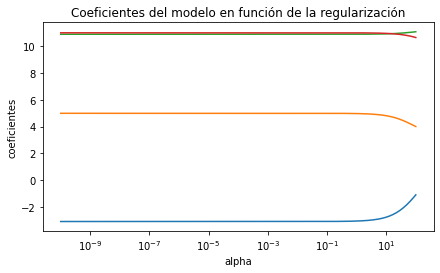

Mejor valor de alpha encontrado: 87.03591361485148


In [20]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo_Ridge = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

_ = modelo_Ridge.fit(X = X, y = y)

# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_Ridge.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo_Ridge.alpha_}")

## Lasso

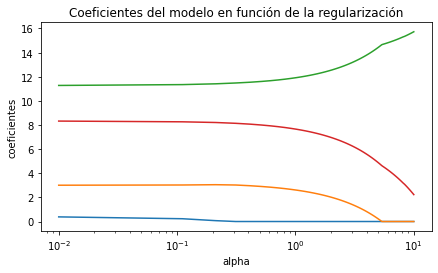

Mejor valor de alpha encontrado: 0.6154545454545455


In [21]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo_Lasso = LassoCV(
            alphas          = np.linspace(0.01, 10, 100),
            fit_intercept   = True
         )

_ = modelo_Lasso.fit(X = X, y = y)

# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_Lasso.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo_Lasso.alpha_}")

## ElasticNet

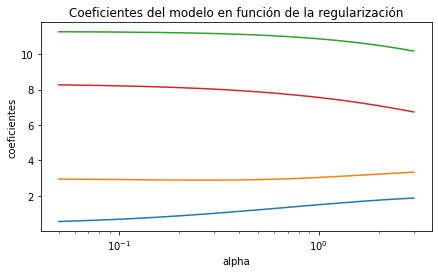

Mejor valor de alpha encontrado: 0.31683417085427135


In [22]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
modelo_ElasticNet = ElasticNetCV(
            l1_ratio        = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.linspace(0.05, 3, 200),
            cv              = 5
         )

_ = modelo_ElasticNet.fit(X = X, y = y)

# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo_ElasticNet.alphas
coefs = []

for alpha in alphas:
    modelo_temp = ElasticNet(alpha=alpha)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo_ElasticNet.alpha_}")

## Install Boosting methods

In [103]:
!pip install lightgbm
!pip install XGBoost
!pip3 install catboost

## Tree

In [24]:
from sklearn.tree import DecisionTreeRegressor

In [50]:
parameters = {'splitter':['best', 'random'],
              'max_depth':[None,3,6], 
              #'min_samples_split':[0.01,0.5,0.9],
              'max_features':[None, 'auto', 'sqrt', 'log2']
              #'n_estimators':[100,200,]
             }

tree_model = DecisionTreeRegressor()

grid_tree = GridSearchCV(estimator = tree_model,
                 param_grid = parameters,
                 scoring='neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True)
grid_tree.fit(X = X , y = y)
print(grid_tree.best_params_)

{'max_depth': None, 'max_features': None, 'splitter': 'random'}


In [51]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_tree.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_max_depth,param_max_features,param_splitter,mean_test_score,std_test_score,mean_train_score,std_train_score
1,None,None,random,-10.655205,3.215448,-0.886907,0.336029
3,None,auto,random,-12.463079,3.803038,-0.884757,0.338316
4,None,sqrt,best,-12.495407,5.627311,-0.888224,0.327370
5,None,sqrt,random,-13.398345,3.231200,-0.886078,0.339041
2,None,auto,best,-13.527307,4.007500,-0.882848,0.337431


## lightgbm

In [52]:
import lightgbm as lgb

In [98]:
parameters = {'num_leaves':[13,16,19],
              'boosting_type':['gbdt','goss'], 
              'reg_alpha':[0,0.2,0.4],
              'learning_rate':[0.05, 0.04,0.03],
              'n_estimators':[1000,1500,2000,3000]
             }

lgb_model = lgb.LGBMRegressor()

grid_lgb = GridSearchCV(estimator = lgb_model,
                 param_grid = parameters,
                 scoring='neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True)
grid_lgb.fit(X = X , y = y)
print(grid_lgb.best_params_)

{'boosting_type': 'gbdt', 'learning_rate': 0.04, 'n_estimators': 1500, 'num_leaves': 16, 'reg_alpha': 0.4}


In [99]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_lgb.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_boosting_type,param_learning_rate,param_n_estimators,param_num_leaves,param_reg_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
50,gbdt,0.04,1500,16,0.4,-12.327291,2.049461,-6.275996,0.830632
52,gbdt,0.04,1500,19,0.2,-12.332187,2.076627,-6.148576,0.838524
5,gbdt,0.05,1000,16,0.4,-12.343983,2.061520,-6.598084,0.859345
7,gbdt,0.05,1000,19,0.2,-12.354970,1.997047,-6.466449,0.873456
8,gbdt,0.05,1000,19,0.4,-12.355906,2.001455,-6.472142,0.879866


## xgboost

In [59]:
from xgboost import XGBRegressor

In [129]:
parameters = {'max_depth':[5,7,9],
              'colsample_bytree':[0,0.5,1], 
              'subsample':[0,0.5,1],
              'min_child_weight': [0,0.5,1],
              'eta':[0.05,0.04,0.03],
              'n_estimators':[800,1500,2000]
             }

XGB_model = XGBRegressor()

grid_XGB = GridSearchCV(estimator = XGB_model,
                 param_grid = parameters,
                 scoring='neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True)
grid_XGB.fit(X = X , y = y)
print(grid_XGB.best_params_)

{'colsample_bytree': 1, 'eta': 0.04, 'max_depth': 5, 'min_child_weight': 0, 'n_estimators': 1500, 'subsample': 1}


In [130]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_XGB.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_colsample_bytree,param_eta,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
590,1,0.04,5,1,1500,1,-10.077030,5.340060,-1.005201,0.298307
581,1,0.04,5,0.5,1500,1,-10.077030,5.340060,-1.005201,0.298307
572,1,0.04,5,0,1500,1,-10.077030,5.340060,-1.005201,0.298307
593,1,0.04,5,1,2000,1,-10.081293,5.341801,-0.933857,0.315527
584,1,0.04,5,0.5,2000,1,-10.081293,5.341801,-0.933857,0.315527


## CatBoost

In [104]:
from catboost import CatBoostRegressor

In [112]:
parameters = {'depth'         : [3,4,5],
              'learning_rate' : [0.03,0.04,0.05],
              'iterations'    : [1500,1800,2100],
              'l2_leaf_reg': [0.5,1]
             }

CAT_model = CatBoostRegressor(verbose=0)

grid_CAT = GridSearchCV(estimator = CAT_model,
                 param_grid = parameters,
                 scoring='neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True)
grid_CAT.fit(X = X , y = y)
print(grid_CAT.best_params_)

{'depth': 5, 'iterations': 1800, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}


In [113]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_CAT.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,mean_test_score,std_test_score,mean_train_score,std_train_score
42,5,1800,0.5,0.03,-8.941961,4.149834,-1.630001,0.202971
48,5,2100,0.5,0.03,-8.945898,4.146758,-1.474067,0.202417
36,5,1500,0.5,0.03,-8.963530,4.129736,-1.852910,0.201873
38,5,1500,0.5,0.05,-9.092230,4.073677,-1.374705,0.216444
44,5,1800,0.5,0.05,-9.102178,4.064698,-1.249049,0.219132


## AdaBoost

In [64]:
from sklearn.ensemble import AdaBoostRegressor

In [120]:
parameters = {'loss': ['linear', 'square', 'exponential'],
              'learning_rate':[0.03,0.1,0.05,0.03],
              'n_estimators':[500, 700, 900]
             }

ADA_model = AdaBoostRegressor()

grid_ADA = GridSearchCV(estimator = ADA_model,
                 param_grid = parameters,
                 scoring='neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True)
grid_ADA.fit(X = X , y = y)
print(grid_ADA.best_params_)

{'learning_rate': 0.03, 'loss': 'exponential', 'n_estimators': 700}


In [121]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_ADA.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_learning_rate,param_loss,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
57,0.03,exponential,700,-15.797903,3.100549,-12.998234,0.392781
41,0.05,exponential,500,-15.814339,3.016409,-12.933997,0.396785
13,0.03,exponential,900,-15.857374,3.083488,-12.897105,0.395997
12,0.03,exponential,700,-15.899761,3.082308,-12.969053,0.473594
58,0.03,exponential,900,-15.929799,3.005070,-13.011353,0.442860


## All

In [74]:
from timeit import default_timer as timer
import timeit

In [131]:
ML_algorithm = []
time = []
RMSE_train = []
RMSE_test = []
r2_train = []
r2_test = []

stimators = {'Linear':LinearRegression(),
             'Lasso': Lasso(alpha=0.61),
             'Ridge': Ridge(alpha=87),
             'ElasticNet': Ridge(alpha=0.31),
             'Tree': DecisionTreeRegressor(max_depth=None, max_features=None, splitter= 'random'),
             'LGBM': lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.04, n_estimators=1500, num_leaves=16, reg_alpha=0.4),
             'XGBoost': XGBRegressor(colsample_bytree=1, min_child_weight=0, eta=0.05, max_depth=7, n_estimators=800, subsample= 0.5),
             'CATBoost': CatBoostRegressor(verbose=0, depth=5, learning_rate=0.03, iterations=1800, l2_leaf_reg=0.5),
             'AdaBoost': AdaBoostRegressor(learning_rate=0.03, loss= 'exponential', n_estimators= 700)
            }

for name, stimator in stimators.items():
    
    time_aux = []
    RMSE_train_aux = []
    RMSE_test_aux = []
    r2_train_aux = []
    r2_test_aux = []
    
    print('Processing with:', name)
    
    for j in range(1,2):
        
        start = timer()
        stimator.fit(X_train,y_train)
        elapsed_time = timer() - start
    
        y_pred_train = stimator.predict(X_train)
        y_pred_test = stimator.predict(X_test)
                
        time_aux.append(round(elapsed_time,3))
        RMSE_train_aux.append(round(mse(y_train, y_pred_train, squared=False),3))
        RMSE_test_aux.append(round(mse(y_test, y_pred_test, squared=False),3))
        r2_train_aux.append(round(r2_score(y_train, y_pred_train),3))
        r2_test_aux.append(round(r2_score(y_test, y_pred_test),3))
        
    ML_algorithm.append(name)
    time.append(np.mean(time_aux))
    RMSE_train.append(np.mean(RMSE_train_aux))
    RMSE_test.append(np.mean(RMSE_test_aux))
    r2_train.append(np.mean(r2_train_aux))
    r2_test.append(np.mean(r2_test_aux))

Processing with: Linear
Processing with: Lasso
Processing with: Ridge
Processing with: ElasticNet
Processing with: Tree
Processing with: LGBM
Processing with: XGBoost
Processing with: CATBoost
Processing with: AdaBoost


In [132]:
df = pd.DataFrame()
df['model'] = ML_algorithm
df['exec_time'] = time
df['RMSE_train'] = RMSE_train
df['RMSE_test'] = RMSE_test
df['r^2_train'] = r2_train
df['r^2_test'] = r2_test

print(df)

        model  exec_time  RMSE_train  RMSE_test  r^2_train  r^2_test
0      Linear      0.002      14.784     15.704      0.946     0.946
1       Lasso      0.002      14.794     15.766      0.945     0.946
2       Ridge      0.002      14.800     15.747      0.945     0.946
3  ElasticNet      0.002      14.784     15.704      0.946     0.946
4        Tree      0.002       0.186     13.522      1.000     0.960
5        LGBM      0.446       5.934     15.543      0.991     0.947
6     XGBoost      1.783       0.436     14.332      1.000     0.955
7    CATBoost      0.523       1.277     11.835      1.000     0.969
8    AdaBoost      0.696      12.152     15.881      0.963     0.945


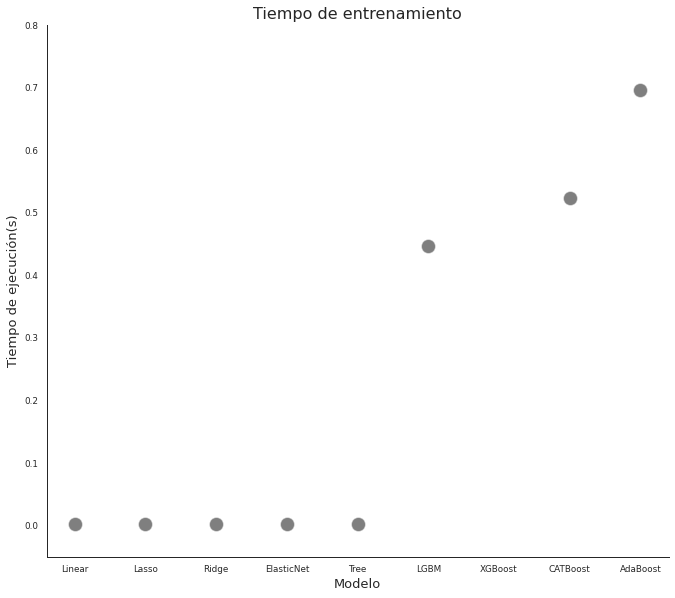

In [149]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="model", y="exec_time", alpha=.5, palette='r', s=200, color = 'black',
            height=6, data=df) \
    .set(title='Tiempo de entrenamiento', xlabel='Modelo', ylabel='Tiempo de ejecución(s)',
        ylim=(-0.05,0.8))
plt.gcf().set_size_inches(11, 9)

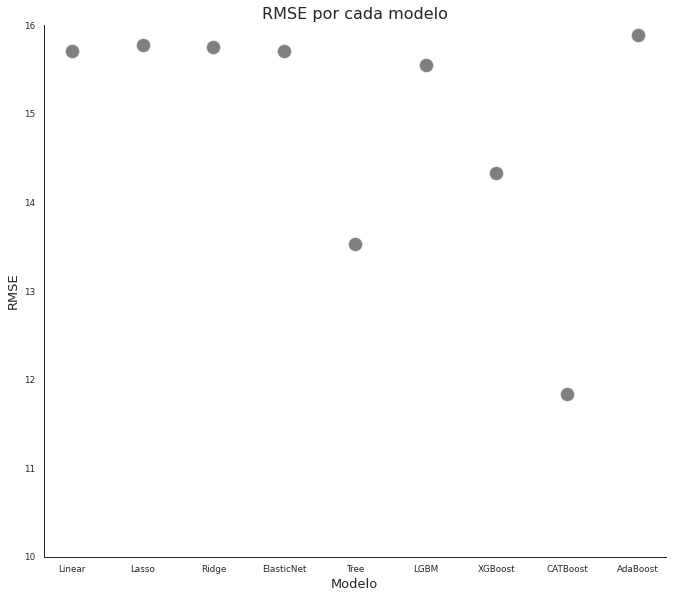

In [150]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   


sns.relplot(x="model", y="RMSE_test", alpha=.5, palette='r', s=200, color = 'black',
            height=6, data=df) \
    .set(title='RMSE por cada modelo', xlabel='Modelo', ylabel='RMSE',
        ylim=(10,16))
plt.gcf().set_size_inches(11, 9)

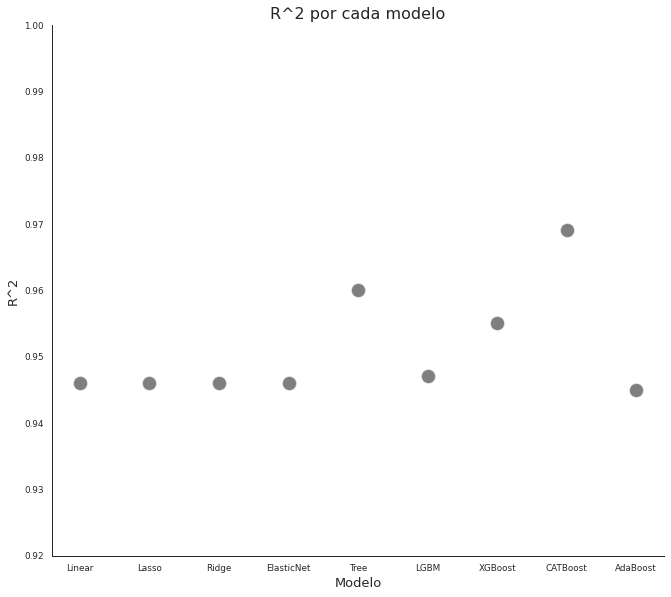

In [153]:
sns.set_theme(style="white")
sns.set_context("paper", rc={"font.size":20,"axes.titlesize":16,"axes.labelsize":13})   

sns.relplot(x="model", y="r^2_test", alpha=.5, palette='r', s=200, color = 'black',
            height=6, data=df) \
    .set(title='R^2 por cada modelo', xlabel='Modelo', ylabel='R^2',
        ylim=(0.92,1))
plt.gcf().set_size_inches(11, 9)